# Instance Generation for Tabu Search Testing

This notebook generates 24 test instances following the cartesian product:
- **Grid Size**: {small, medium, large} = 3 options
- **Obstacles**: {no obstacles, many small ones} = 2 options
- **Border**: {no obstacle border, with border} = 2 options
- **Sprayer Length**: {small (12), large (20)} = 2 options

Total: 3 × 2 × 2 × 2 = 24 instances

In [16]:
from agricultural_csp.instance import AgcspInstance
from agricultural_csp.evaluator import AgcspEvaluator
from agricultural_csp.solution import AgcspSolution
from agricultural_csp.solver.agcsp_ts import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

Node = Tuple[float, float]

In [17]:
def display_grid_and_path(inst, evaluator, path, title_suffix=""):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
        title_suffix: Additional text to add to the title
    """
    covered_nodes = evaluator.get_covered_nodes_list(path) if len(path) > 0 else []
    
    total_nodes = inst.target_node_count
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(10, 8))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    if len(path) > 0:
        path_arr = np.array(path)
        plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=2, 
                label='Sprayer Path', marker='o', markersize=4, markerfacecolor='white', 
                markeredgecolor='#9900CC', markeredgewidth=1.5)
        
        # Plot start point (green star)
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=150, 
                   marker='*', label='Start', edgecolors='black', linewidths=1.5, zorder=5)
        
        # Plot end point (red square)
        if len(path) > 1:
            plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=80, 
                       marker='s', label='End', edgecolors='black', linewidths=1.5, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9, fontsize=8)
    
    title = f'{title_suffix}\nCoverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=10, fontweight='bold')
    
    print(f"{title_suffix}")
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

## Instance Generation Functions

In [18]:
def create_instance(size, obstacle_type, border, sprayer_length=10, max_turn_angle=90, seed=None):
    """
    Create an instance based on the specified parameters.
    
    Args:
        size: 'small', 'medium', or 'large'
        obstacle_type: 'none', 'few_small', 'many_small', or 'few_large'
        border: True for obstacle border, False for no border
        sprayer_length: Length of the sprayer bar
        max_turn_angle: Maximum turn angle in degrees
        seed: Random seed for reproducibility (optional)
    
    Returns:
        AgcspInstance object
    """
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Define grid sizes
    size_map = {
        'small': 50,
        'medium': 100,
        'large': 150
    }
    grid_size = size_map[size]
    
    # Create square grid
    r_grid, c_grid = np.mgrid[0:grid_size, 0:grid_size]
    grid_nodes = np.argwhere((r_grid >= 0) & (r_grid < grid_size) & 
                              (c_grid >= 0) & (c_grid < grid_size))
    
    obstacle_list = []
    
    # Add border obstacles if requested
    if border:
        border_width = 2
        # Top border
        top_border = np.argwhere((r_grid < border_width) & 
                                  (c_grid >= 0) & (c_grid < grid_size))
        # Bottom border
        bottom_border = np.argwhere((r_grid >= grid_size - border_width) & 
                                     (c_grid >= 0) & (c_grid < grid_size))
        # Left border
        left_border = np.argwhere((c_grid < border_width) & 
                                   (r_grid >= 0) & (r_grid < grid_size))
        # Right border
        right_border = np.argwhere((c_grid >= grid_size - border_width) & 
                                    (r_grid >= 0) & (r_grid < grid_size))
        obstacle_list.extend([top_border, bottom_border, left_border, right_border])
    
    # Define margin to avoid placing obstacles too close to borders
    margin = 10
    
    # Add internal obstacles based on type
    if obstacle_type == 'few_small':
        # Up to 3 small obstacles at random positions
        obstacle_half_size = 2
        num_obstacles = 3
        
        for i in range(num_obstacles):
            # Random position with margin
            obs_r = np.random.randint(margin, grid_size - margin)
            obs_c = np.random.randint(margin, grid_size - margin)
            obstacle = np.argwhere(
                (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
                (np.abs(c_grid - obs_c) <= obstacle_half_size)
            )
            obstacle_list.append(obstacle)
    
    elif obstacle_type == 'many_small':
        # Many small obstacles at random positions
        obstacle_half_size = 2
        num_obstacles = max(5, grid_size // 20)  # Scale with grid size
        
        for i in range(num_obstacles):
            # Random position with margin
            obs_r = np.random.randint(margin, grid_size - margin)
            obs_c = np.random.randint(margin, grid_size - margin)
            obstacle = np.argwhere(
                (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
                (np.abs(c_grid - obs_c) <= obstacle_half_size)
            )
            obstacle_list.append(obstacle)
    
    elif obstacle_type == 'few_large':
        # 2 large obstacles at random positions
        obstacle_half_size = max(5, grid_size // 15)
        num_obstacles = 2
        
        for i in range(num_obstacles):
            # Random position with larger margin to accommodate larger obstacles
            larger_margin = margin + obstacle_half_size
            obs_r = np.random.randint(larger_margin, grid_size - larger_margin)
            obs_c = np.random.randint(larger_margin, grid_size - larger_margin)
            obstacle = np.argwhere(
                (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
                (np.abs(c_grid - obs_c) <= obstacle_half_size)
            )
            obstacle_list.append(obstacle)
    
    # Combine all obstacles
    if obstacle_list:
        obstacle_nodes = np.vstack(obstacle_list)
    else:
        obstacle_nodes = np.array([])
    
    # Create instance
    instance = AgcspInstance(grid_nodes, obstacle_nodes, sprayer_length, max_turn_angle)
    
    return instance

## Generate All 36 Instances

In [19]:
# Define the cartesian product parameters
sizes = ['small', 'medium', 'large']
obstacle_types = ['none', 'many_small', 'few_large']
borders = [False, True]
sprayer_lengths = [12, 20]  # small and large sprayer lengths

# Generate all instances (3 x 3 x 2 x 2 = 36)
instances = {}
instance_counter = 1

for size in sizes:
    for obstacle_type in obstacle_types:
        for border in borders:
            for sprayer_length in sprayer_lengths:
                # Create descriptive name
                border_str = "with_border" if border else "no_border"
                sprayer_str = f"spray{sprayer_length}"
                instance_name = f"inst_{instance_counter:02d}_{size}_{obstacle_type}_{border_str}_{sprayer_str}"
                
                print(f"Creating {instance_name}...")
                
                # Create instance with specified sprayer length
                inst = create_instance(size, obstacle_type, border, sprayer_length=sprayer_length)
                
                # Store instance with metadata
                instances[instance_name] = {
                    'instance': inst,
                    'size': size,
                    'obstacle_type': obstacle_type,
                    'border': border,
                    'sprayer_length': sprayer_length,
                    'evaluator': AgcspEvaluator(inst)
                }
                
                instance_counter += 1

print(f"\n✓ Successfully created {len(instances)} instances")

Creating inst_01_small_none_no_border_spray12...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (1348 nós)
Creating inst_02_small_none_no_border_spray20...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (1741 nós)
Creating inst_03_small_none_with_border_spray12...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (1797 nós)
Creating inst_04_small_none_with_border_spray20...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (2253 nós)
Creating inst_05_small_many_small_no_border_spray12...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (2187 nós)
Creating inst_06_small_many_small_no_border_spray20...
Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (2500 nós)
Creating inst_07_small_many_small_with_border_spray12...
Grid Adaptativo: Densidade original (2500)
Grid Ada

## Visualize All Instances

Display all 36 instances without any paths (empty paths).

inst_01_small_none_no_border_spray12: small, none, no border, sprayer=12
Coverage: 0/2500 nodes (0.0%)


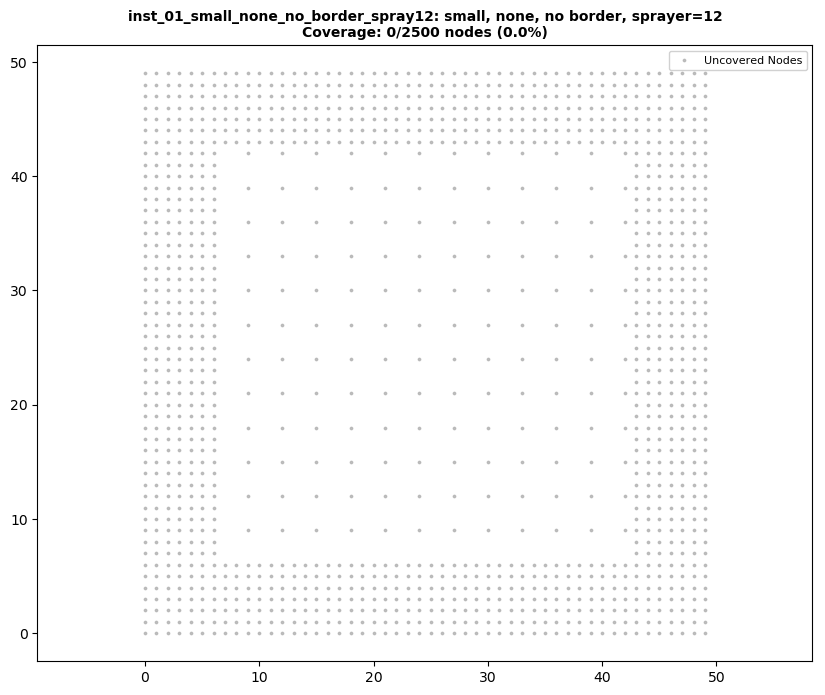

--------------------------------------------------------------------------------
inst_02_small_none_no_border_spray20: small, none, no border, sprayer=20
Coverage: 0/2500 nodes (0.0%)


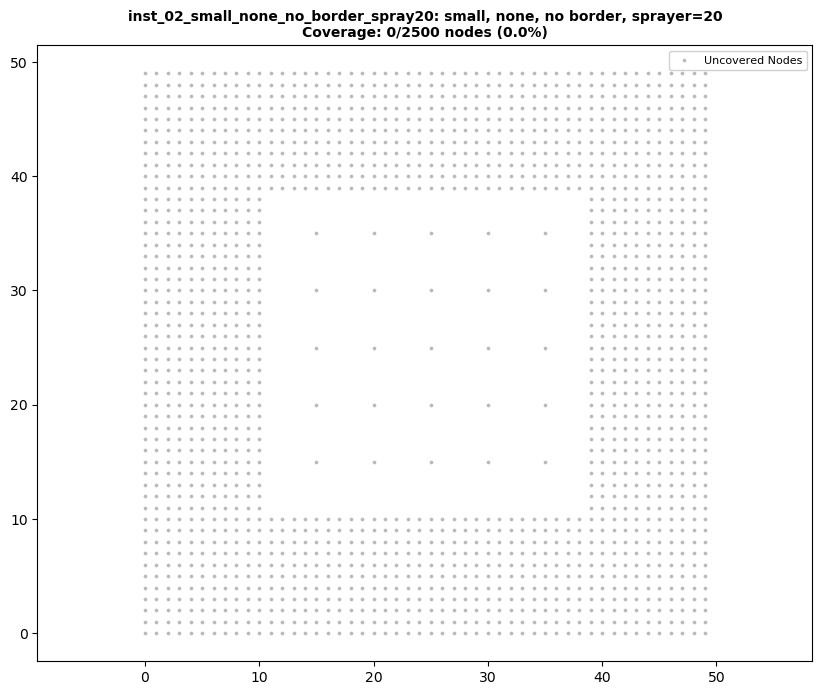

--------------------------------------------------------------------------------
inst_03_small_none_with_border_spray12: small, none, with border, sprayer=12
Coverage: 0/2060 nodes (0.0%)
Obstacles: 0/456 covered


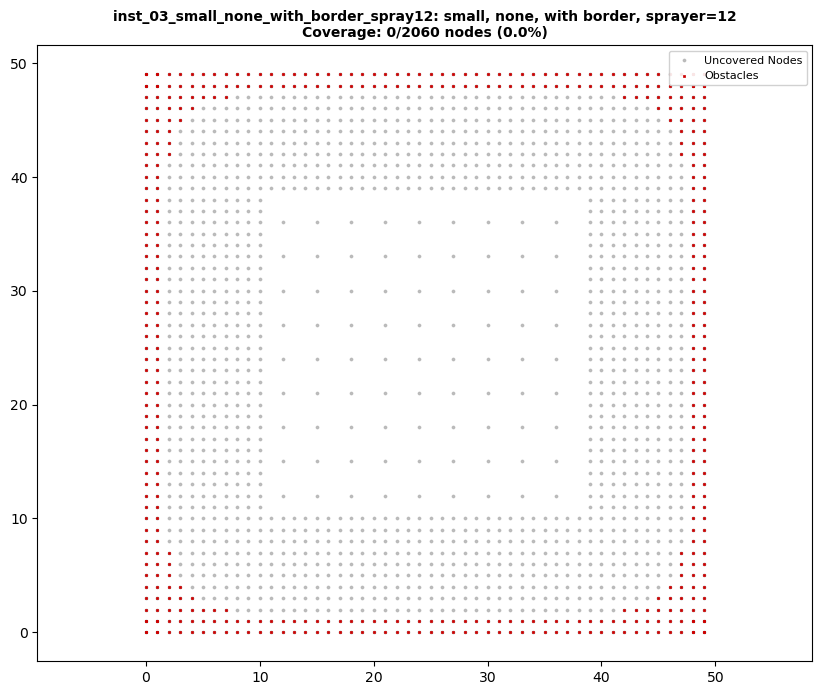

--------------------------------------------------------------------------------
inst_04_small_none_with_border_spray20: small, none, with border, sprayer=20
Coverage: 0/1992 nodes (0.0%)
Obstacles: 0/524 covered


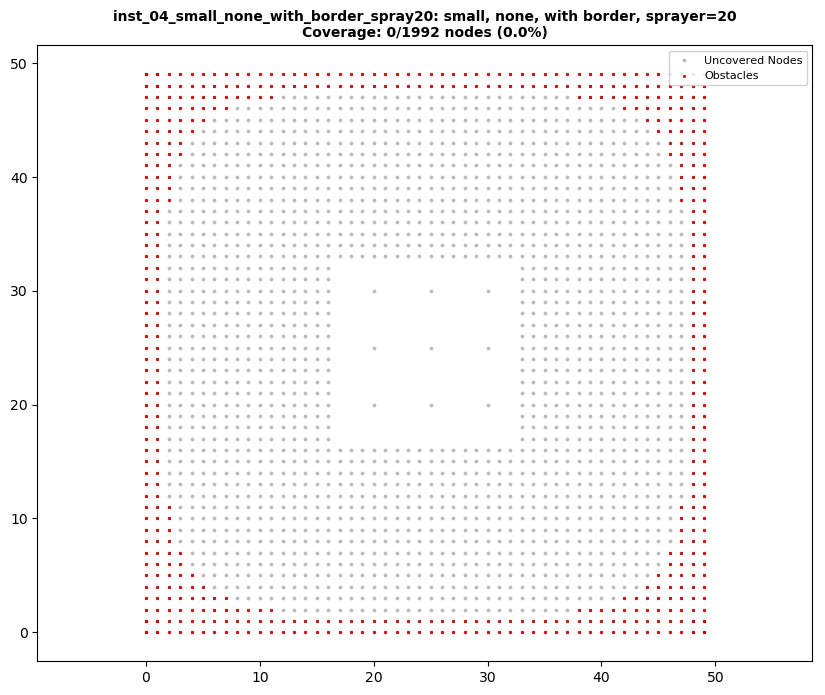

--------------------------------------------------------------------------------
inst_05_small_many_small_no_border_spray12: small, many small, no border, sprayer=12
Coverage: 0/2331 nodes (0.0%)
Obstacles: 0/169 covered


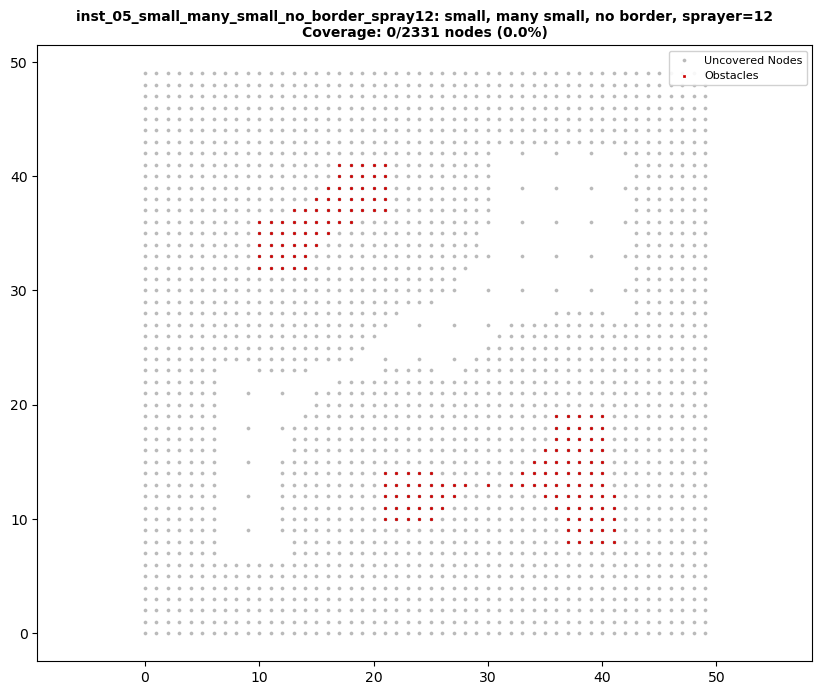

--------------------------------------------------------------------------------
inst_06_small_many_small_no_border_spray20: small, many small, no border, sprayer=20
Coverage: 0/2111 nodes (0.0%)
Obstacles: 0/391 covered


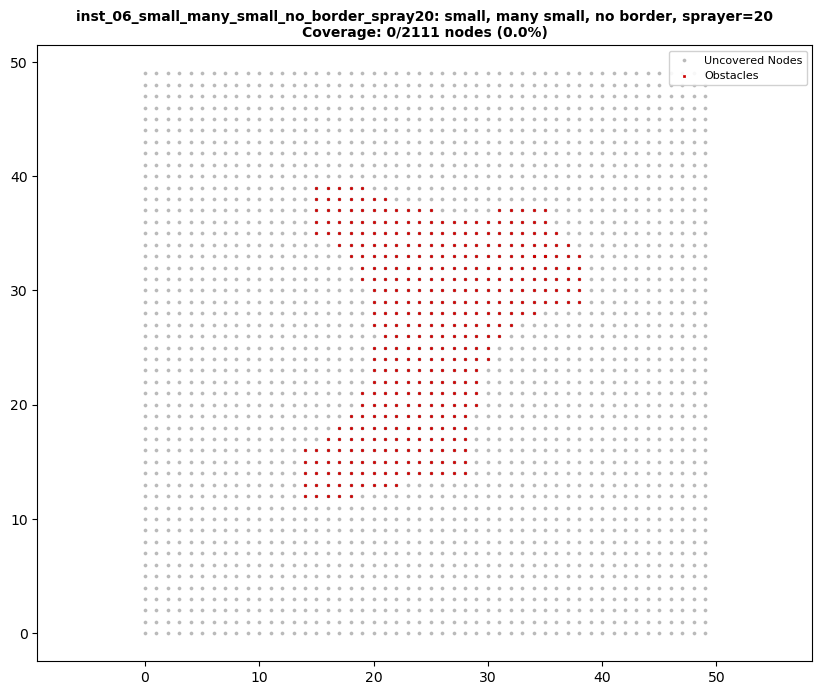

--------------------------------------------------------------------------------
inst_07_small_many_small_with_border_spray12: small, many small, with border, sprayer=12
Coverage: 0/1568 nodes (0.0%)
Obstacles: 0/948 covered


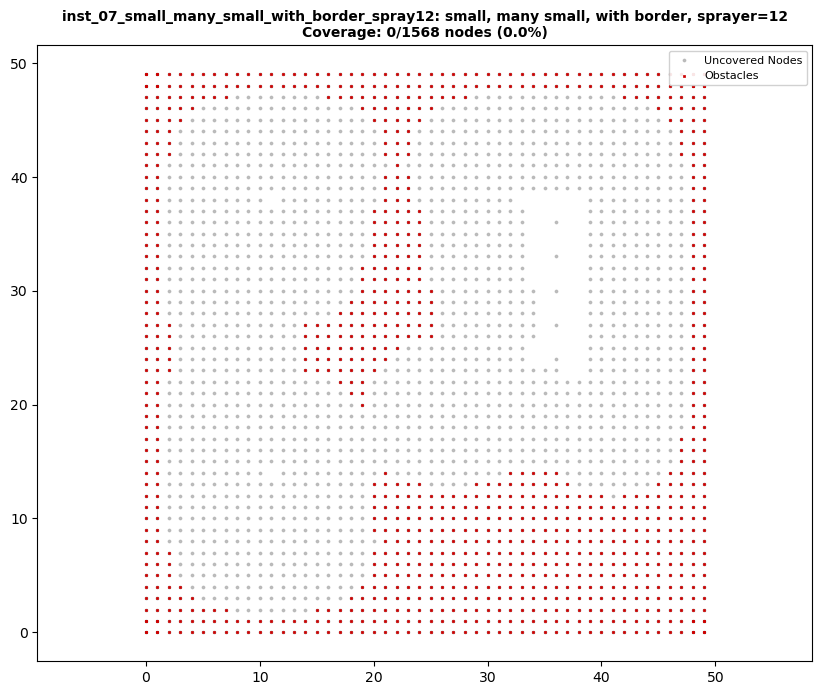

--------------------------------------------------------------------------------
inst_08_small_many_small_with_border_spray20: small, many small, with border, sprayer=20
Coverage: 0/779 nodes (0.0%)
Obstacles: 0/1743 covered


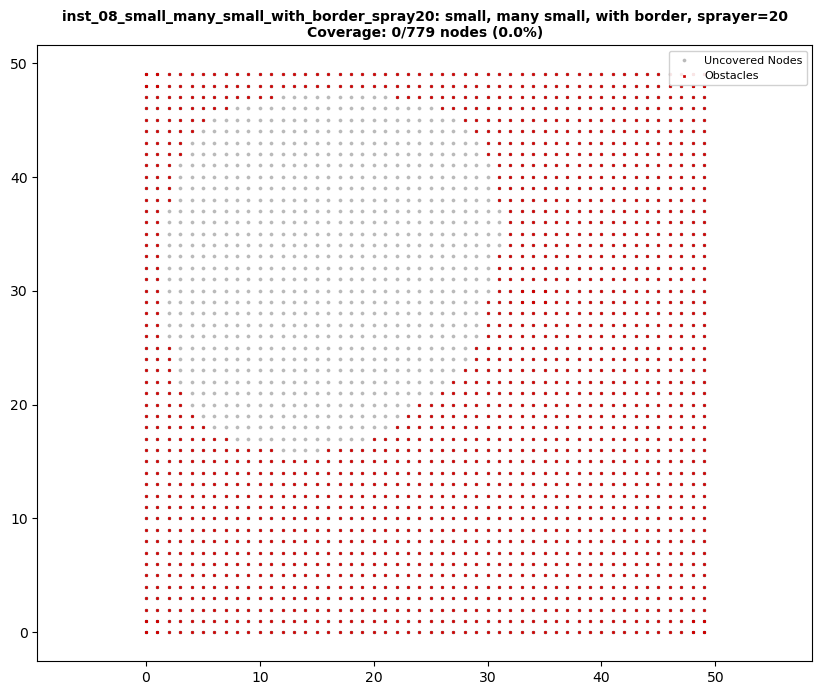

--------------------------------------------------------------------------------
inst_09_small_few_large_no_border_spray12: small, few large, no border, sprayer=12
Coverage: 0/2196 nodes (0.0%)
Obstacles: 0/304 covered


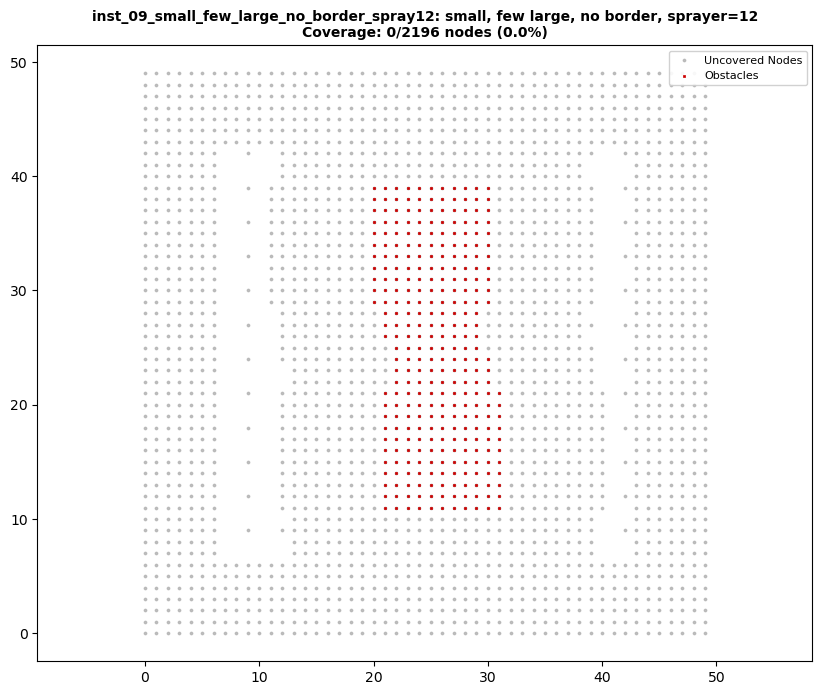

--------------------------------------------------------------------------------
inst_10_small_few_large_no_border_spray20: small, few large, no border, sprayer=20
Coverage: 0/2216 nodes (0.0%)
Obstacles: 0/284 covered


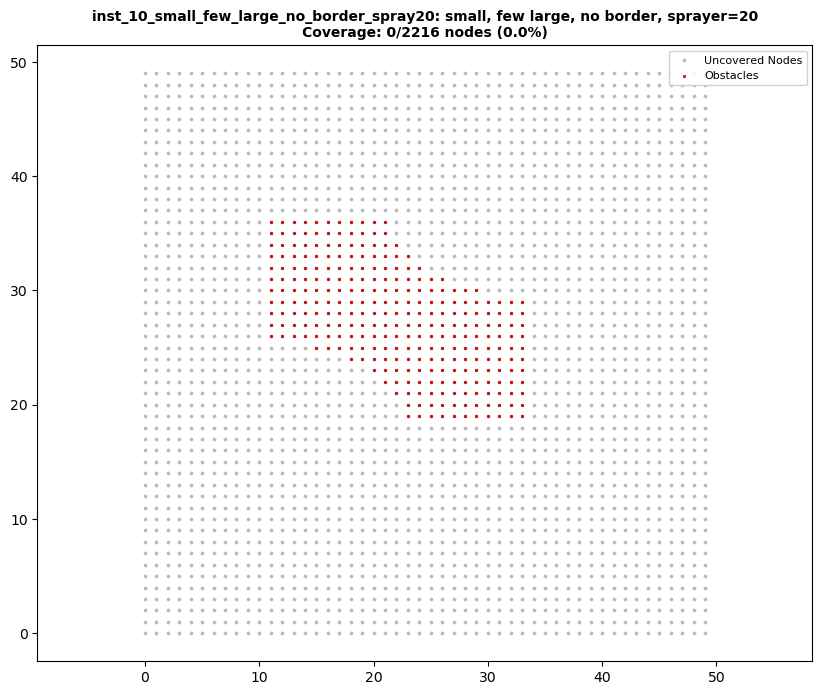

--------------------------------------------------------------------------------
inst_11_small_few_large_with_border_spray12: small, few large, with border, sprayer=12
Coverage: 0/1703 nodes (0.0%)
Obstacles: 0/813 covered


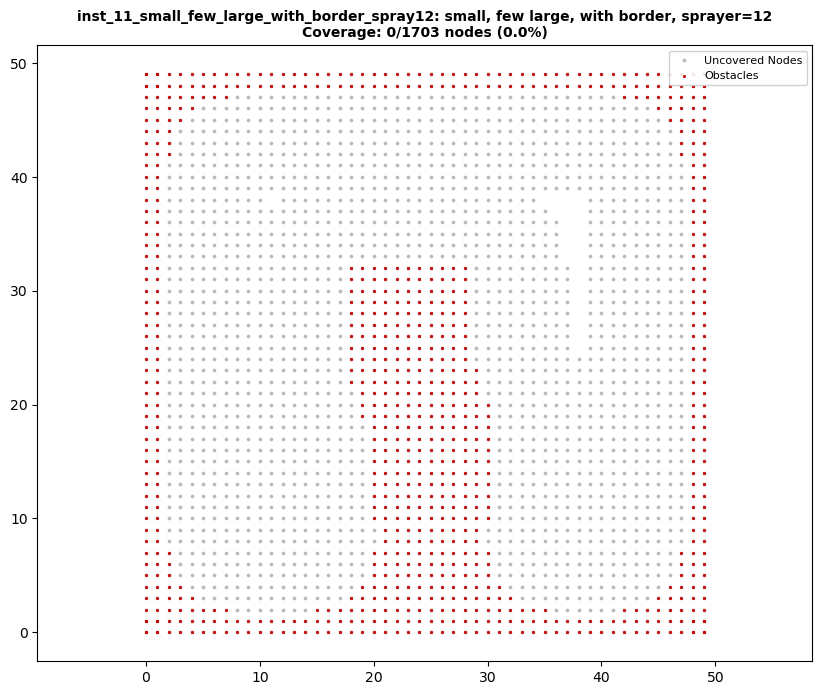

--------------------------------------------------------------------------------
inst_12_small_few_large_with_border_spray20: small, few large, with border, sprayer=20
Coverage: 0/892 nodes (0.0%)
Obstacles: 0/1624 covered


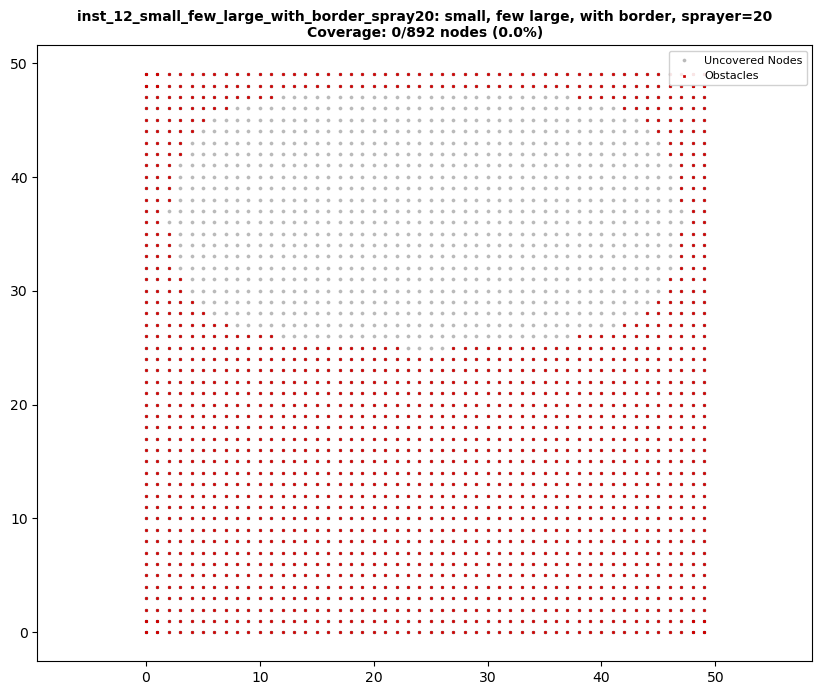

--------------------------------------------------------------------------------
inst_13_medium_none_no_border_spray12: medium, none, no border, sprayer=12
Coverage: 0/10000 nodes (0.0%)


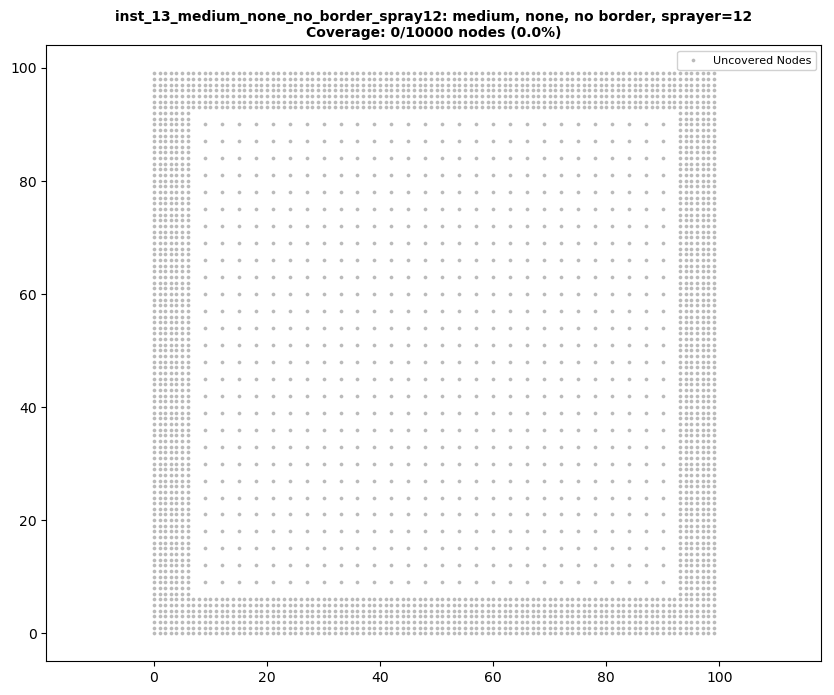

--------------------------------------------------------------------------------
inst_14_medium_none_no_border_spray20: medium, none, no border, sprayer=20
Coverage: 0/10000 nodes (0.0%)


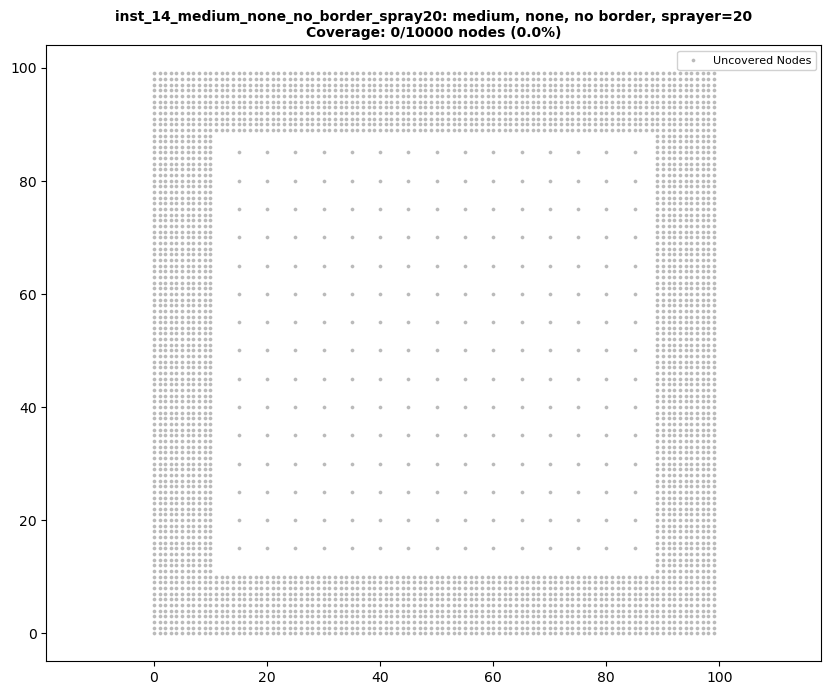

--------------------------------------------------------------------------------
inst_15_medium_none_with_border_spray12: medium, none, with border, sprayer=12
Coverage: 0/9160 nodes (0.0%)
Obstacles: 0/856 covered
inst_15_medium_none_with_border_spray12: medium, none, with border, sprayer=12
Coverage: 0/9160 nodes (0.0%)
Obstacles: 0/856 covered


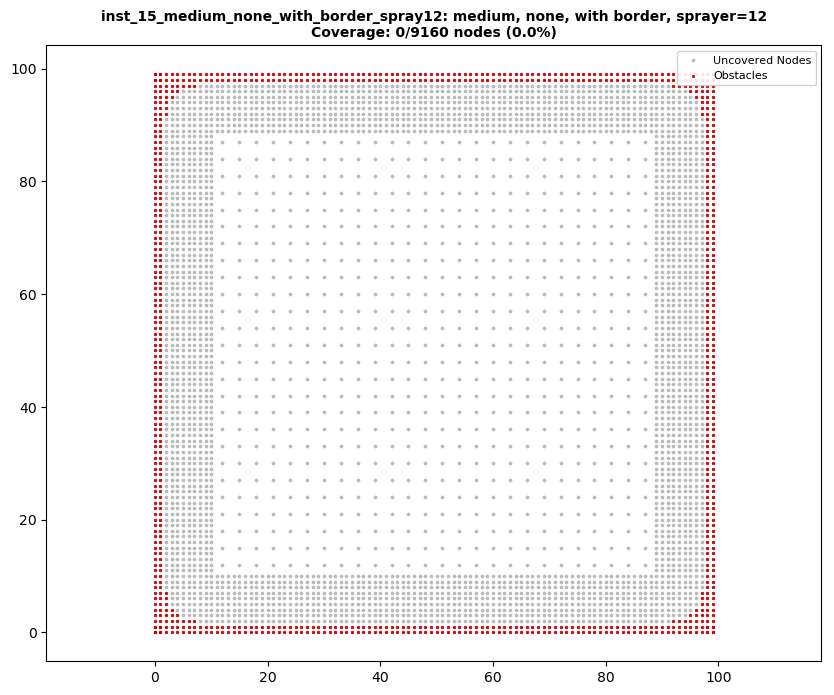

--------------------------------------------------------------------------------
inst_16_medium_none_with_border_spray20: medium, none, with border, sprayer=20
Coverage: 0/9092 nodes (0.0%)
Obstacles: 0/924 covered


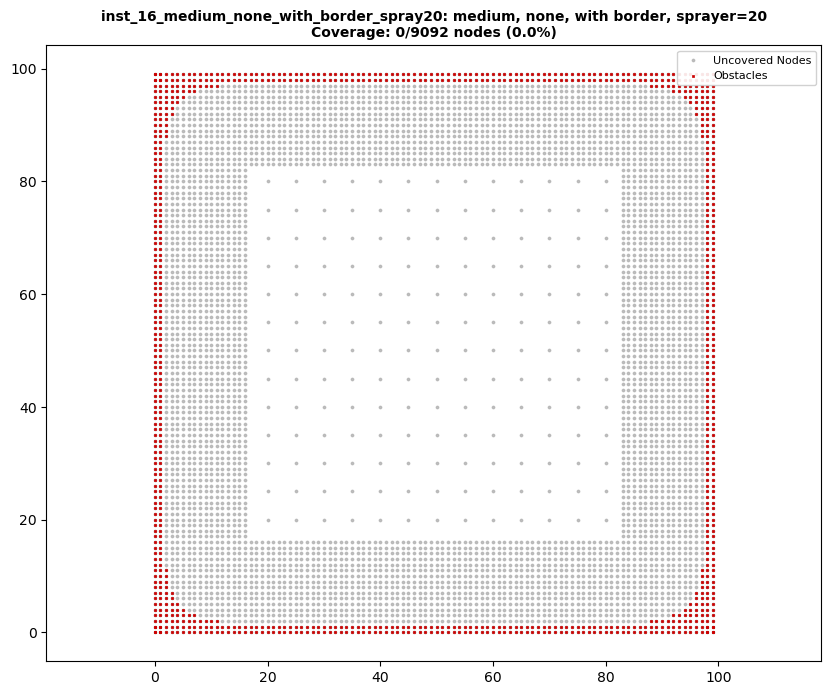

--------------------------------------------------------------------------------
inst_17_medium_many_small_no_border_spray12: medium, many small, no border, sprayer=12
Coverage: 0/9879 nodes (0.0%)
Obstacles: 0/129 covered
inst_17_medium_many_small_no_border_spray12: medium, many small, no border, sprayer=12
Coverage: 0/9879 nodes (0.0%)
Obstacles: 0/129 covered


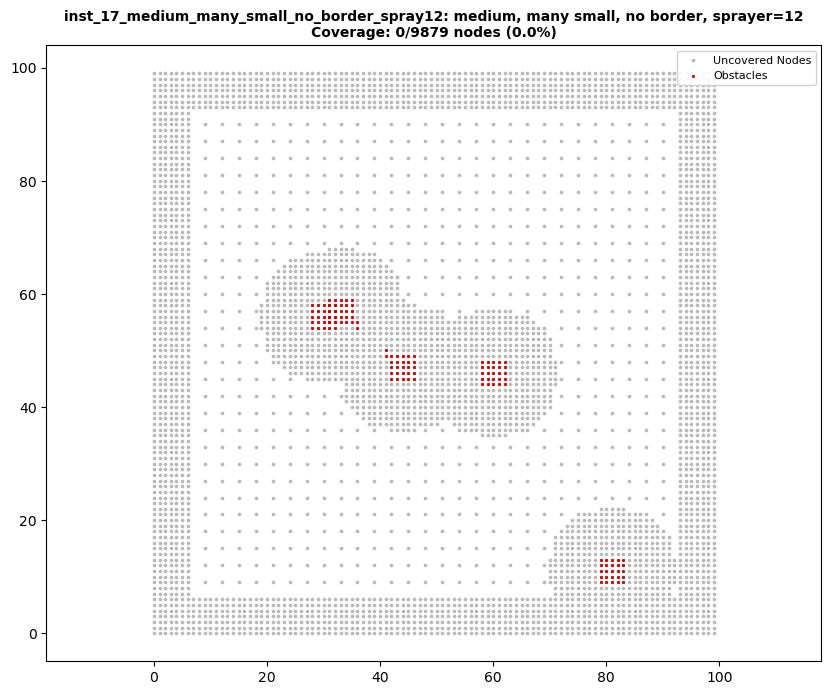

--------------------------------------------------------------------------------
inst_18_medium_many_small_no_border_spray20: medium, many small, no border, sprayer=20
Coverage: 0/9870 nodes (0.0%)
Obstacles: 0/130 covered
inst_18_medium_many_small_no_border_spray20: medium, many small, no border, sprayer=20
Coverage: 0/9870 nodes (0.0%)
Obstacles: 0/130 covered


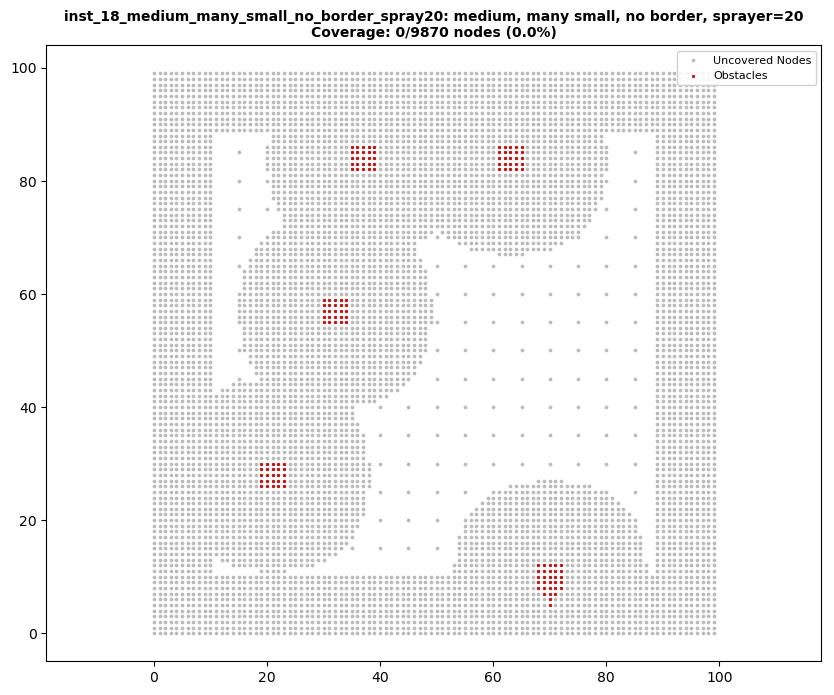

--------------------------------------------------------------------------------
inst_19_medium_many_small_with_border_spray12: medium, many small, with border, sprayer=12
Coverage: 0/8849 nodes (0.0%)
Obstacles: 0/1167 covered
inst_19_medium_many_small_with_border_spray12: medium, many small, with border, sprayer=12
Coverage: 0/8849 nodes (0.0%)
Obstacles: 0/1167 covered


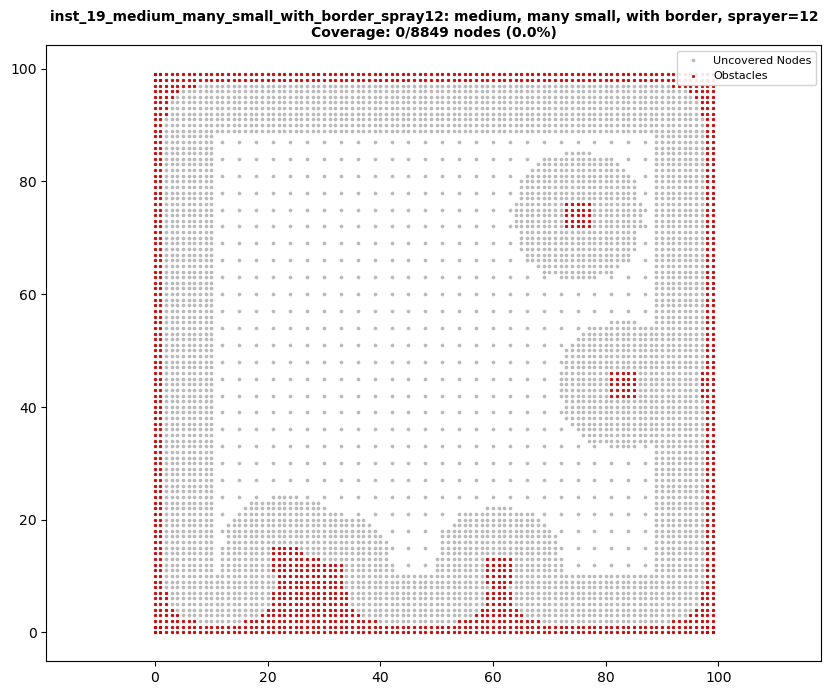

--------------------------------------------------------------------------------
inst_20_medium_many_small_with_border_spray20: medium, many small, with border, sprayer=20
Coverage: 0/8374 nodes (0.0%)
Obstacles: 0/1642 covered
inst_20_medium_many_small_with_border_spray20: medium, many small, with border, sprayer=20
Coverage: 0/8374 nodes (0.0%)
Obstacles: 0/1642 covered


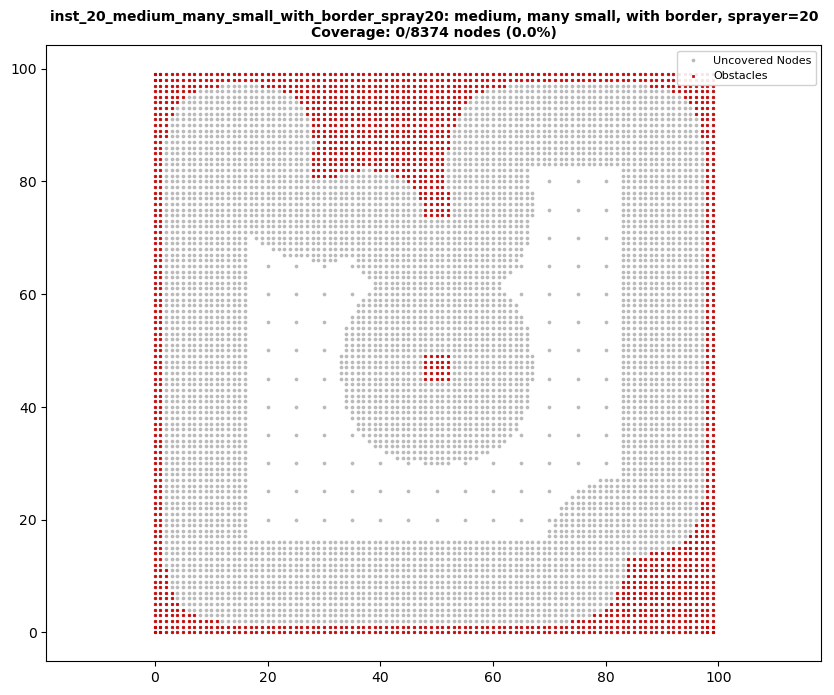

--------------------------------------------------------------------------------
inst_21_medium_few_large_no_border_spray12: medium, few large, no border, sprayer=12
Coverage: 0/9662 nodes (0.0%)
Obstacles: 0/338 covered
inst_21_medium_few_large_no_border_spray12: medium, few large, no border, sprayer=12
Coverage: 0/9662 nodes (0.0%)
Obstacles: 0/338 covered


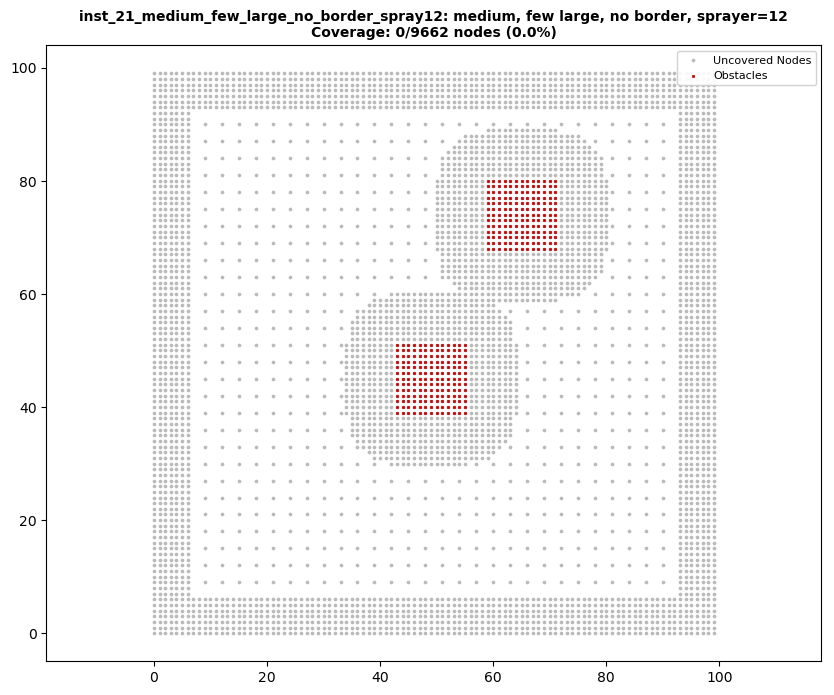

--------------------------------------------------------------------------------
inst_22_medium_few_large_no_border_spray20: medium, few large, no border, sprayer=20
Coverage: 0/9616 nodes (0.0%)
Obstacles: 0/384 covered


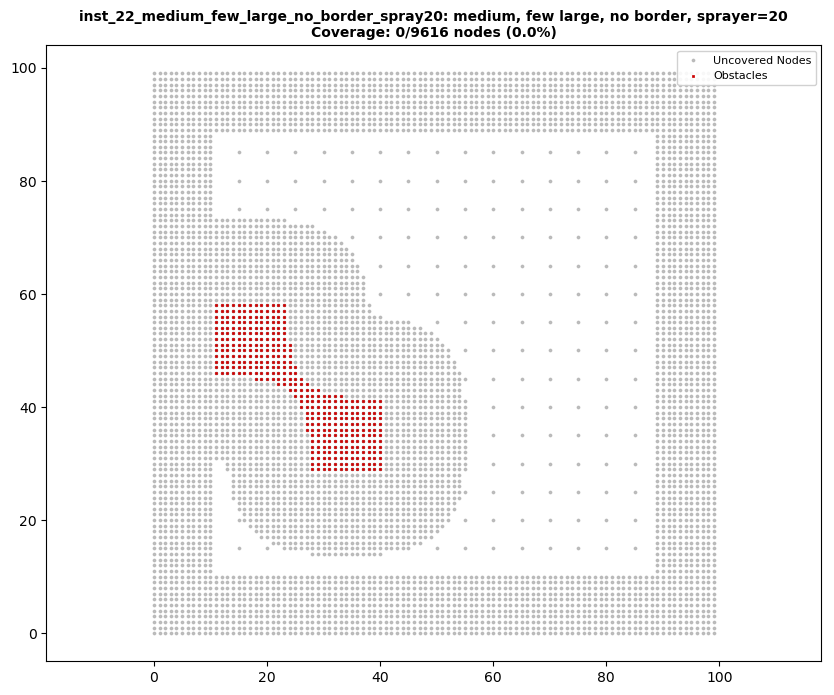

--------------------------------------------------------------------------------
inst_23_medium_few_large_with_border_spray12: medium, few large, with border, sprayer=12
Coverage: 0/8706 nodes (0.0%)
Obstacles: 0/1340 covered


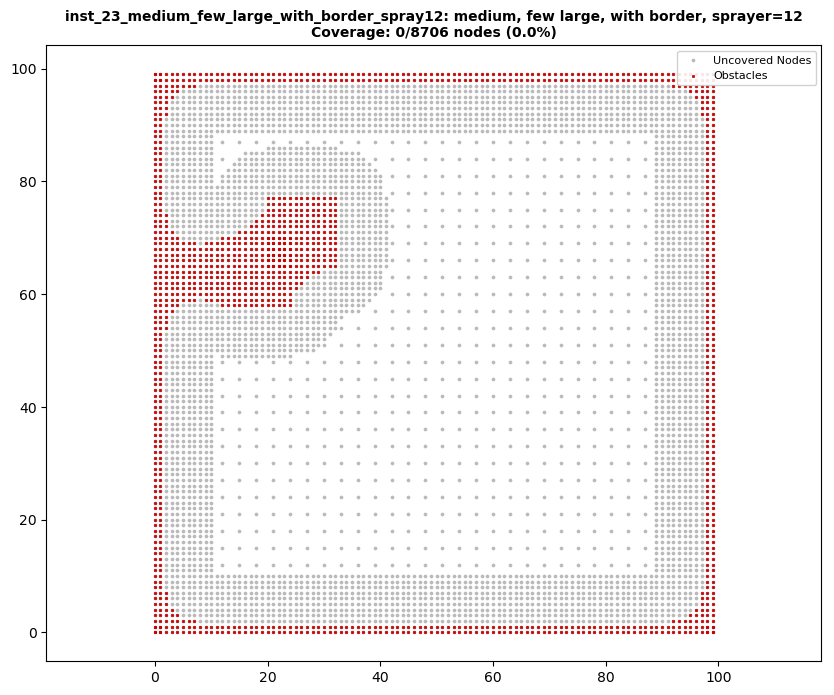

--------------------------------------------------------------------------------
inst_24_medium_few_large_with_border_spray20: medium, few large, with border, sprayer=20
Coverage: 0/8701 nodes (0.0%)
Obstacles: 0/1315 covered
inst_24_medium_few_large_with_border_spray20: medium, few large, with border, sprayer=20
Coverage: 0/8701 nodes (0.0%)
Obstacles: 0/1315 covered


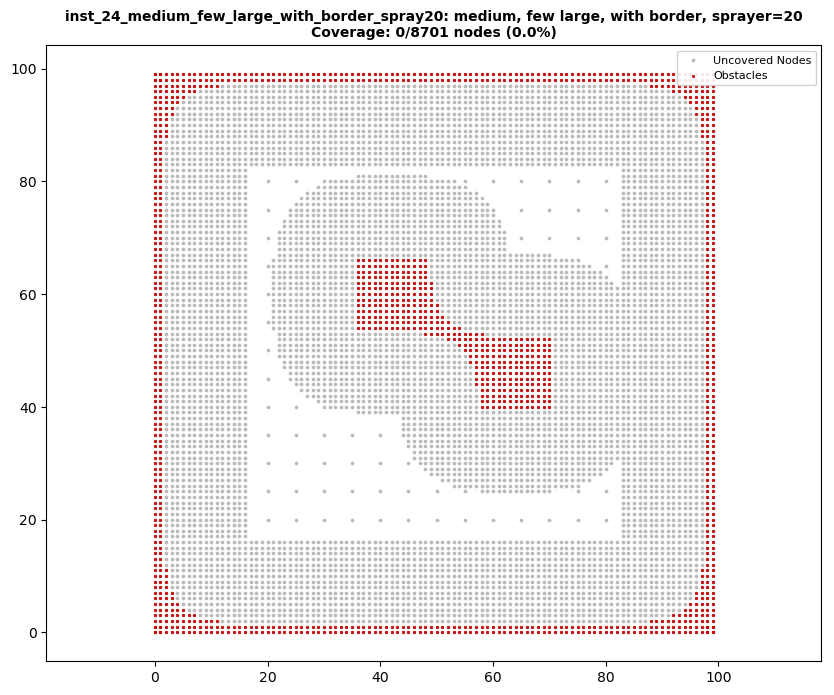

--------------------------------------------------------------------------------
inst_25_large_none_no_border_spray12: large, none, no border, sprayer=12
Coverage: 0/22500 nodes (0.0%)


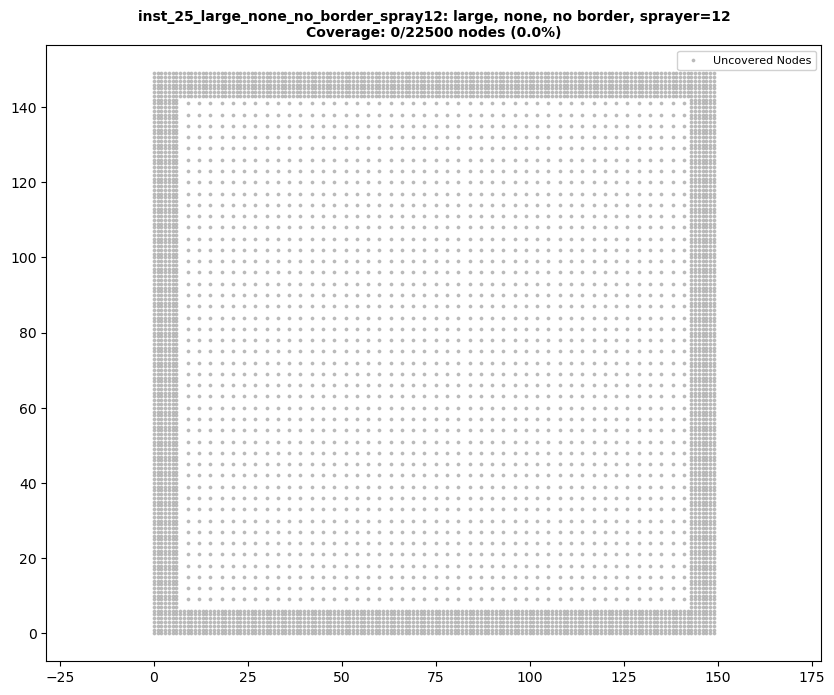

--------------------------------------------------------------------------------
inst_26_large_none_no_border_spray20: large, none, no border, sprayer=20
Coverage: 0/22500 nodes (0.0%)
inst_26_large_none_no_border_spray20: large, none, no border, sprayer=20
Coverage: 0/22500 nodes (0.0%)


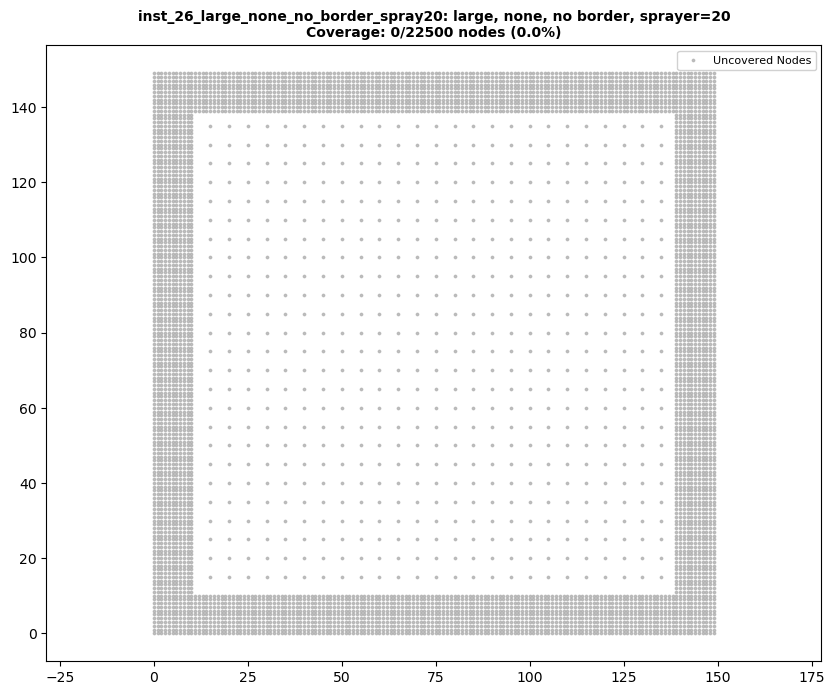

--------------------------------------------------------------------------------
inst_27_large_none_with_border_spray12: large, none, with border, sprayer=12
Coverage: 0/21260 nodes (0.0%)
Obstacles: 0/1256 covered


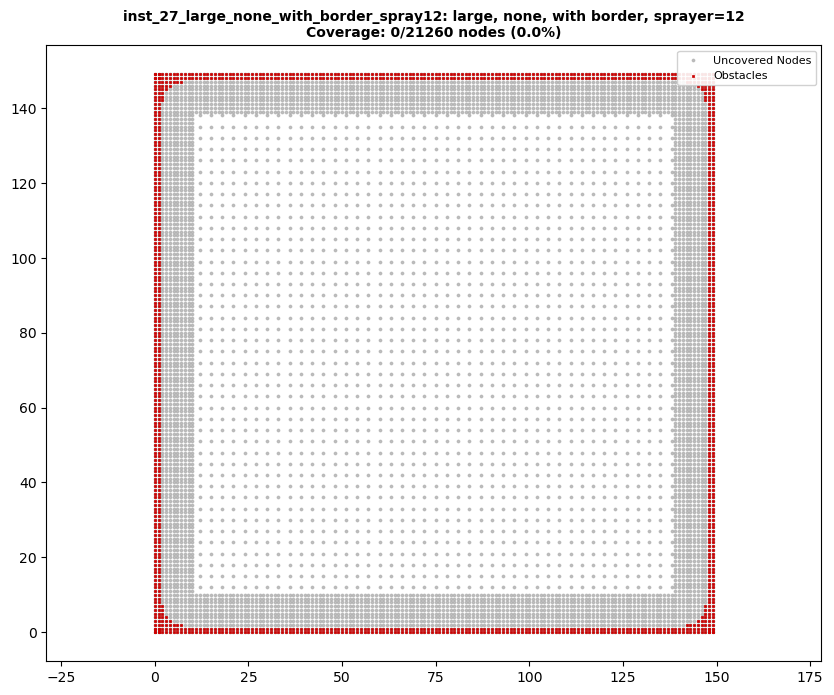

--------------------------------------------------------------------------------
inst_28_large_none_with_border_spray20: large, none, with border, sprayer=20
Coverage: 0/21192 nodes (0.0%)
Obstacles: 0/1324 covered


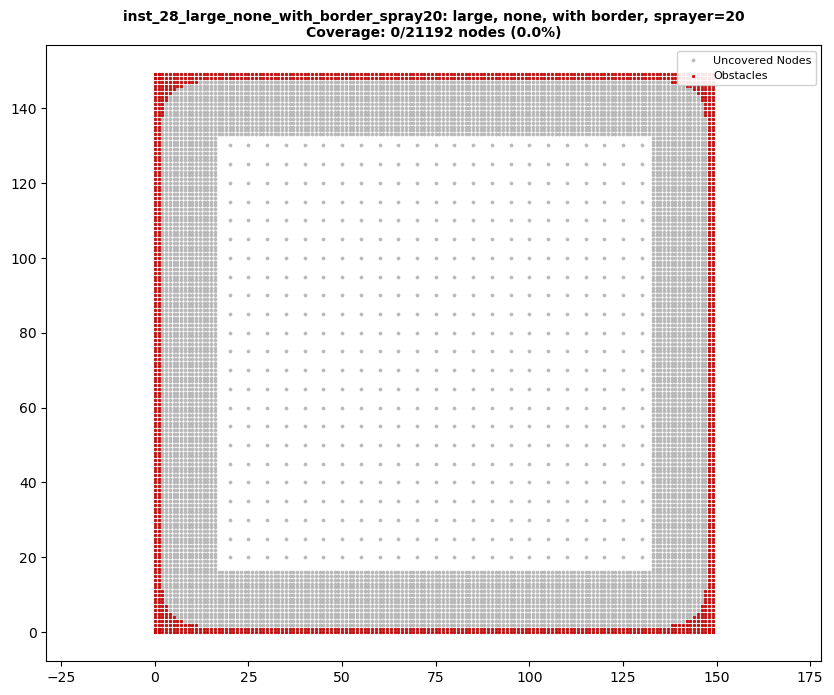

--------------------------------------------------------------------------------
inst_29_large_many_small_no_border_spray12: large, many small, no border, sprayer=12
Coverage: 0/22314 nodes (0.0%)
Obstacles: 0/186 covered


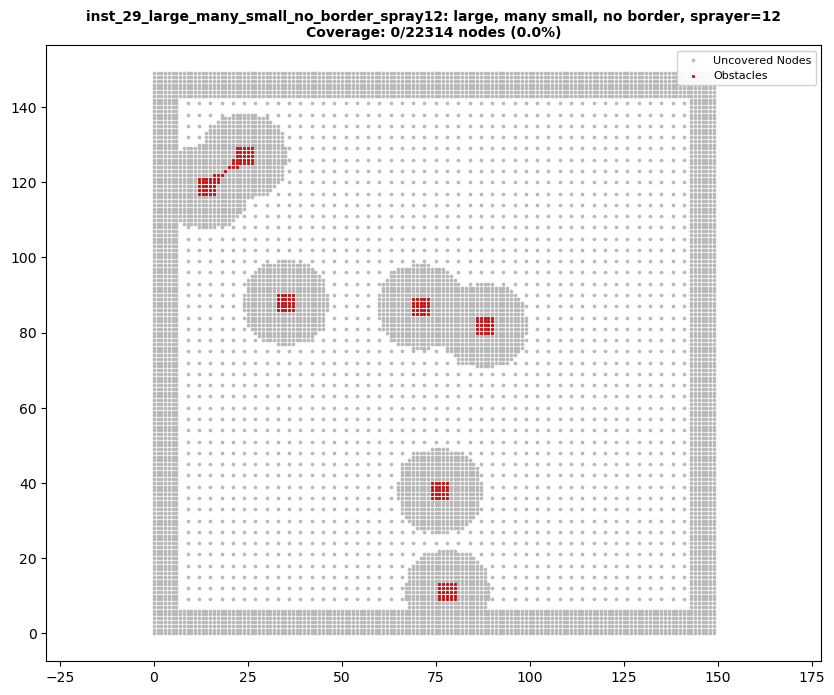

--------------------------------------------------------------------------------
inst_30_large_many_small_no_border_spray20: large, many small, no border, sprayer=20
Coverage: 0/22311 nodes (0.0%)
Obstacles: 0/189 covered
inst_30_large_many_small_no_border_spray20: large, many small, no border, sprayer=20
Coverage: 0/22311 nodes (0.0%)
Obstacles: 0/189 covered


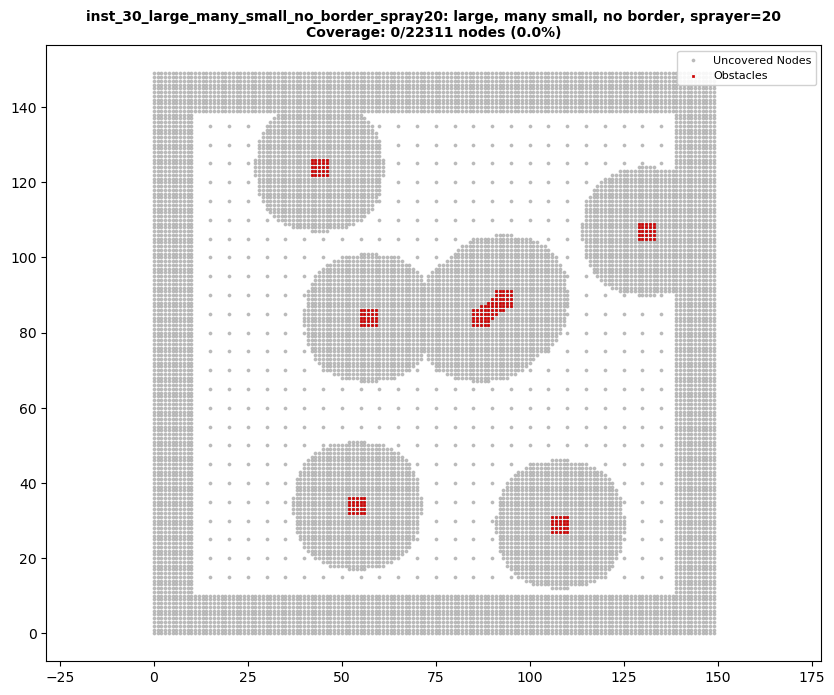

--------------------------------------------------------------------------------
inst_31_large_many_small_with_border_spray12: large, many small, with border, sprayer=12
Coverage: 0/20984 nodes (0.0%)
Obstacles: 0/1532 covered


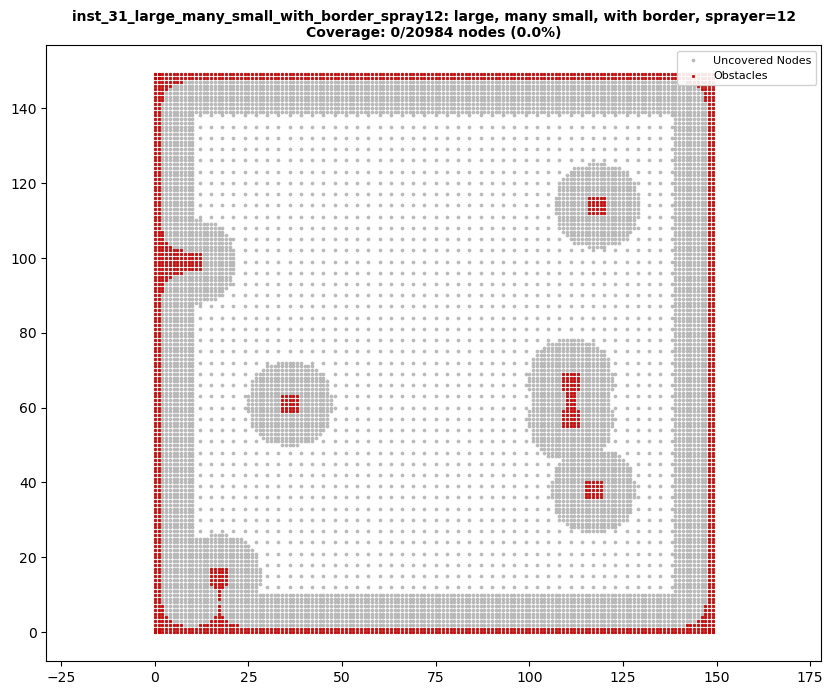

--------------------------------------------------------------------------------
inst_32_large_many_small_with_border_spray20: large, many small, with border, sprayer=20
Coverage: 0/20949 nodes (0.0%)
Obstacles: 0/1567 covered


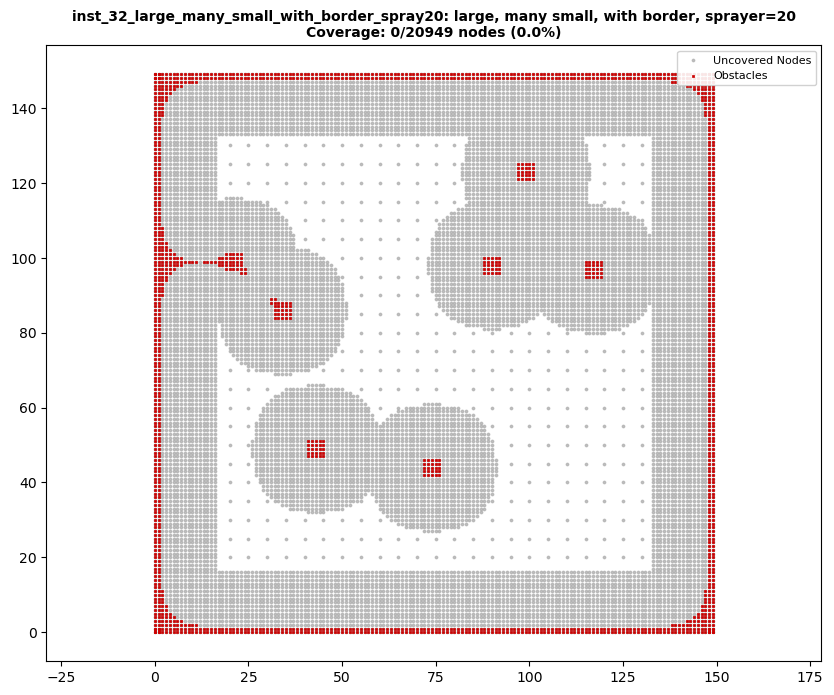

--------------------------------------------------------------------------------
inst_33_large_few_large_no_border_spray12: large, few large, no border, sprayer=12
Coverage: 0/21802 nodes (0.0%)
Obstacles: 0/888 covered


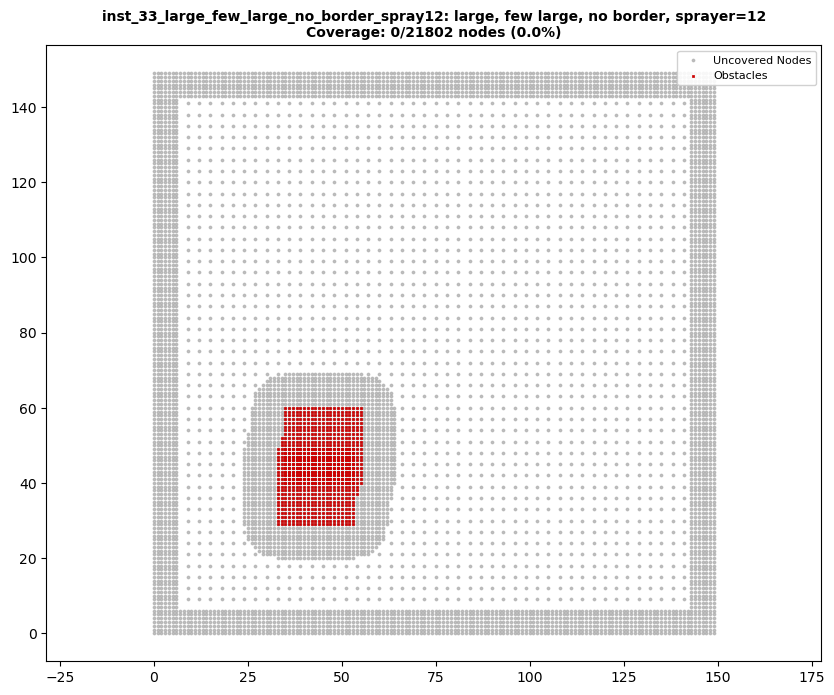

--------------------------------------------------------------------------------
inst_34_large_few_large_no_border_spray20: large, few large, no border, sprayer=20
Coverage: 0/21618 nodes (0.0%)
Obstacles: 0/882 covered


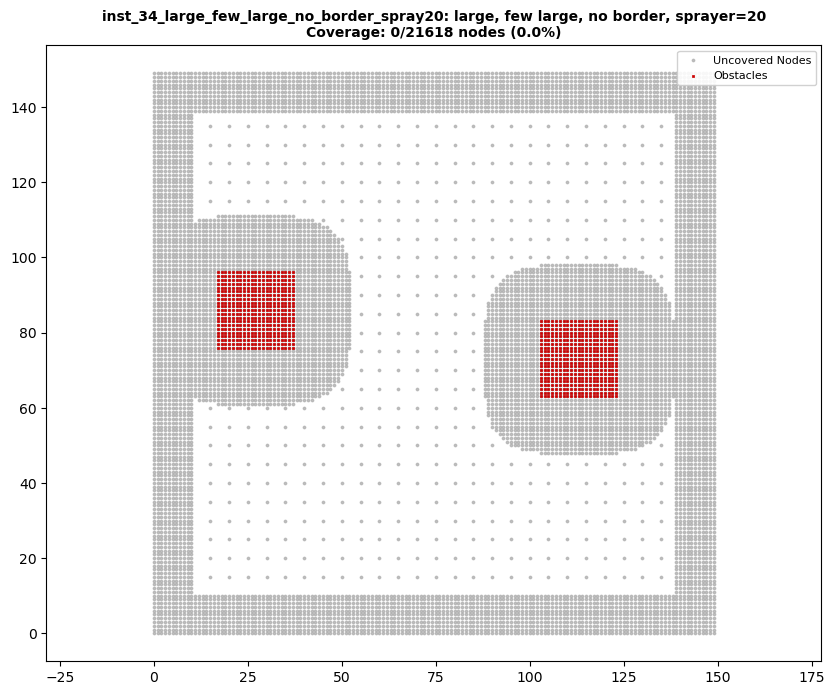

--------------------------------------------------------------------------------
inst_35_large_few_large_with_border_spray12: large, few large, with border, sprayer=12
Coverage: 0/20378 nodes (0.0%)
Obstacles: 0/2138 covered


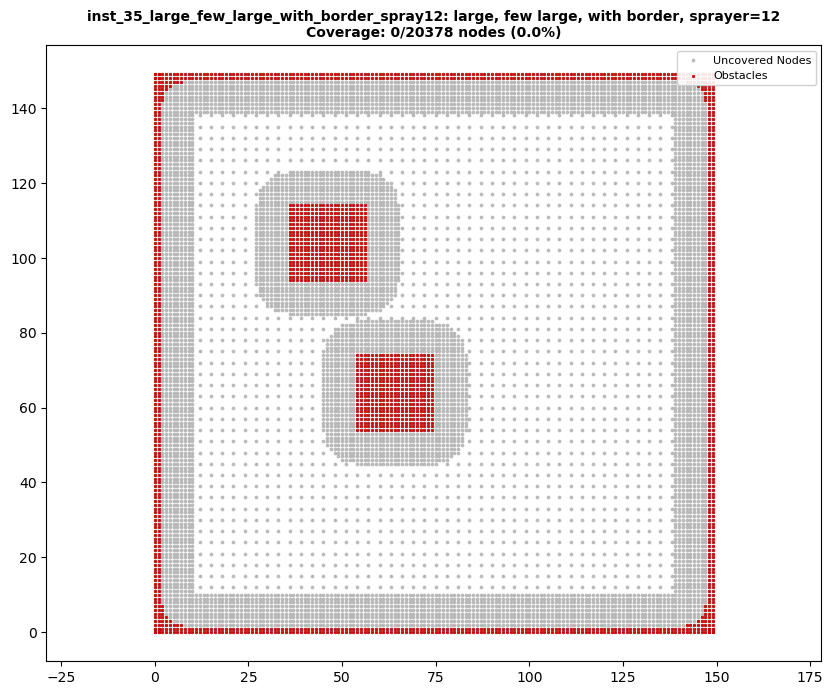

--------------------------------------------------------------------------------
inst_36_large_few_large_with_border_spray20: large, few large, with border, sprayer=20
Coverage: 0/19286 nodes (0.0%)
Obstacles: 0/3230 covered


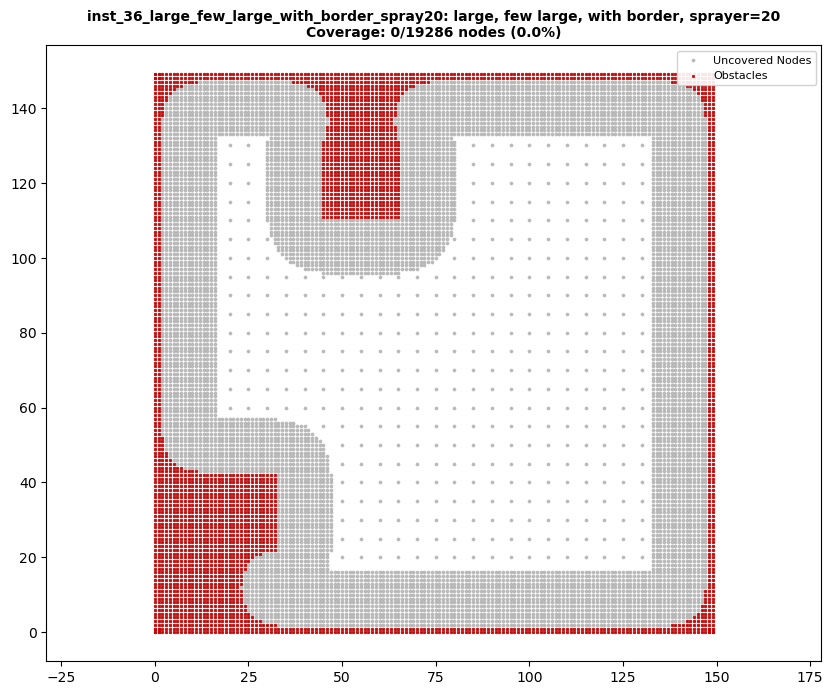

--------------------------------------------------------------------------------


In [20]:
# Visualize all instances with empty paths
for instance_name in sorted(instances.keys()):
    instance_data = instances[instance_name]
    inst = instance_data['instance']
    evaluator = instance_data['evaluator']
    
    # Create title with instance details
    size = instance_data['size']
    obstacle_type = instance_data['obstacle_type'].replace('_', ' ')
    border = "with border" if instance_data['border'] else "no border"
    sprayer_length = instance_data['sprayer_length']
    title = f"{instance_name}: {size}, {obstacle_type}, {border}, sprayer={sprayer_length}"
    
    # Display with empty path
    display_grid_and_path(inst, evaluator, [], title_suffix=title)
    print("-" * 80)

## Instance Summary

Let's create a summary table of all instances with their characteristics.

In [21]:
import pandas as pd

# Create summary data
summary_data = []
for instance_name in sorted(instances.keys()):
    instance_data = instances[instance_name]
    inst = instance_data['instance']
    
    summary_data.append({
        'Instance': instance_name,
        'Size': instance_data['size'],
        'Obstacle Type': instance_data['obstacle_type'],
        'Border': 'Yes' if instance_data['border'] else 'No',
        'Sprayer Length': instance_data['sprayer_length'],
        'Grid Nodes': len(inst.grid_nodes),
        'Target Nodes': inst.target_node_count,
        'Obstacle Nodes': len(inst.obstacle_nodes) if len(inst.obstacle_nodes) > 0 else 0
    })

# Create DataFrame
df = pd.DataFrame(summary_data)
print(df.to_string(index=False))

# Group by categories
print("\n" + "="*80)
print("SUMMARY BY SIZE:")
print(df.groupby('Size').agg({
    'Grid Nodes': 'mean',
    'Target Nodes': 'mean',
    'Obstacle Nodes': 'mean'
}).round(0))

print("\n" + "="*80)
print("SUMMARY BY OBSTACLE TYPE:")
print(df.groupby('Obstacle Type').agg({
    'Grid Nodes': 'mean',
    'Target Nodes': 'mean',
    'Obstacle Nodes': 'mean'
}).round(0))

print("\n" + "="*80)
print("SUMMARY BY SPRAYER LENGTH:")
print(df.groupby('Sprayer Length').agg({
    'Grid Nodes': 'mean',
    'Target Nodes': 'mean',
    'Obstacle Nodes': 'mean'
}).round(0))

                                     Instance   Size Obstacle Type Border  Sprayer Length  Grid Nodes  Target Nodes  Obstacle Nodes
         inst_01_small_none_no_border_spray12  small          none     No              12        1348          2500               0
         inst_02_small_none_no_border_spray20  small          none     No              20        1741          2500               0
       inst_03_small_none_with_border_spray12  small          none    Yes              12        1797          2060             456
       inst_04_small_none_with_border_spray20  small          none    Yes              20        2253          1992             524
   inst_05_small_many_small_no_border_spray12  small    many_small     No              12        2187          2331             169
   inst_06_small_many_small_no_border_spray20  small    many_small     No              20        2500          2111             391
 inst_07_small_many_small_with_border_spray12  small    many_small    Yes   

## Save Instances to Pickle Files

Save all instances to the `agricultural_csp/instances` directory for later use.

In [22]:
import pickle
import os

# Create the instances directory if it doesn't exist
instances_dir = 'agricultural_csp/instances'
os.makedirs(instances_dir, exist_ok=True)

# Save each instance to a pickle file
for instance_name, instance_data in instances.items():
    # Extract just the instance object (not the whole metadata dict)
    inst = instance_data['instance']
    
    # Create filename
    filename = f"{instance_name}.pkl"
    filepath = os.path.join(instances_dir, filename)
    
    # Save to pickle
    with open(filepath, 'wb') as f:
        pickle.dump(inst, f)
    
    print(f"✓ Saved {filename}")

print(f"\n✓ Successfully saved {len(instances)} instances to {instances_dir}/")

# Also save a metadata file with instance information
metadata = {}
for instance_name, instance_data in instances.items():
    inst = instance_data['instance']
    metadata[instance_name] = {
        'size': instance_data['size'],
        'obstacle_type': instance_data['obstacle_type'],
        'border': instance_data['border'],
        'sprayer_length': instance_data['sprayer_length'],
        'grid_nodes_count': len(inst.grid_nodes),
        'target_nodes_count': inst.target_node_count,
        'obstacle_nodes_count': len(inst.obstacle_nodes) if len(inst.obstacle_nodes) > 0 else 0,
        'max_turn_angle': inst.max_turn_angle
    }

metadata_filepath = os.path.join(instances_dir, 'instances_metadata.pkl')
with open(metadata_filepath, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Saved metadata to instances_metadata.pkl")

✓ Saved inst_01_small_none_no_border_spray12.pkl
✓ Saved inst_02_small_none_no_border_spray20.pkl
✓ Saved inst_03_small_none_with_border_spray12.pkl
✓ Saved inst_04_small_none_with_border_spray20.pkl
✓ Saved inst_05_small_many_small_no_border_spray12.pkl
✓ Saved inst_06_small_many_small_no_border_spray20.pkl
✓ Saved inst_07_small_many_small_with_border_spray12.pkl
✓ Saved inst_08_small_many_small_with_border_spray20.pkl
✓ Saved inst_09_small_few_large_no_border_spray12.pkl
✓ Saved inst_10_small_few_large_no_border_spray20.pkl
✓ Saved inst_11_small_few_large_with_border_spray12.pkl
✓ Saved inst_12_small_few_large_with_border_spray20.pkl
✓ Saved inst_13_medium_none_no_border_spray12.pkl
✓ Saved inst_14_medium_none_no_border_spray20.pkl
✓ Saved inst_15_medium_none_with_border_spray12.pkl
✓ Saved inst_16_medium_none_with_border_spray20.pkl
✓ Saved inst_17_medium_many_small_no_border_spray12.pkl
✓ Saved inst_18_medium_many_small_no_border_spray20.pkl
✓ Saved inst_19_medium_many_small_with_b

## Loading Instances (Example)

Here's how to load a saved instance later:

In [23]:
# Example: Load a specific instance
# instance_name = 'inst_01_small_none_no_border'
# filepath = f'agricultural_csp/instances/{instance_name}.pkl'

# with open(filepath, 'rb') as f:
#     loaded_instance = pickle.load(f)

# print(f"Loaded instance: {instance_name}")
# print(f"Target nodes: {loaded_instance.target_node_count}")
# print(f"Grid nodes: {len(loaded_instance.grid_nodes)}")

# Example: Load metadata
# with open('agricultural_csp/instances/instances_metadata.pkl', 'rb') as f:
#     metadata = pickle.load(f)

# print("\nAvailable instances:")
# for name, info in metadata.items():
#     print(f"  {name}: {info['size']}, {info['obstacle_type']}, border={info['border']}")